##Scalling up with Tenserflow in Transfer Learning


In [1]:
!nvidia-smi


Thu Jul 22 06:27:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-22 06:27:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-22 06:27:14 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
#import series of helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir 

##101 food classes :working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

--2021-07-22 06:27:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   182MB/s    in 7.2s    

2021-07-22 06:27:24 (216 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
#chech the image classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_

In [6]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              
                                                              #dont shuffele the test data in order
                                                              shuffle=False)                                                                          

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train a Model with Transfer Learning with 101 classes

steps to follow:

1.create a model checkpoint callback

2.create a data augmenataion layer to augmenataion right into model

3.build headless functional efficientNet back-boned model

4.compile the model

5.feature extract for 5 full passes and validate on 15% data 

##Model Checkpoint Creation

In [7]:
#craete a model check point
checkpoint_path ="101_classes_10_percent_data_model_checkpoint"

checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        monitor="val_accuracy")

##Create data augmentaion layer

In [8]:
#incorate with the model data
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#setup data augmentaion
data_augmentation=Sequential([
                              preprocessing.RandomFlip("horizontal"),
                              preprocessing.RandomRotation(0.2),
                              preprocessing.RandomHeight(0.2),
                              preprocessing.RandomHeight(0.2),
                              preprocessing.RandomWidth(0.2),
                              preprocessing.RandomZoom(0.2),

                              #this should use for resnet models ,efficient net model has inbuilt rescaling
                              # preprocessing.Rescaling(1/255.),

],name="data_augmenation")

In [9]:
#setup the base model and freeze the layers
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#setup the model with trainable top layer
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),
                    activation="softmax",
                    name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)


In [10]:
#get a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmenation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


##Compile and Fit the Model


In [11]:
#compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit 
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 134s 418ms/step - loss: 3.5044 - accuracy: 0.2385 - val_loss: 2.7809 - val_accuracy: 0.3702
Epoch 2/5
237/237 [==============================] - 80s 335ms/step - loss: 2.3970 - accuracy: 0.4487 - val_loss: 2.3397 - val_accuracy: 0.4465
Epoch 3/5
237/237 [==============================] - 70s 294ms/step - loss: 2.0208 - accuracy: 0.5158 - val_loss: 2.1813 - val_accuracy: 0.4515
Epoch 4/5
237/237 [==============================] - 74s 309ms/step - loss: 1.7985 - accuracy: 0.5682 - val_loss: 2.0775 - val_accuracy: 0.4730
Epoch 5/5
237/237 [==============================] - 66s 278ms/step - loss: 1.6224 - accuracy: 0.6022 - val_loss: 1.9910 - val_accuracy: 0.4836


In [12]:
#evaluate the model
feature_exraction_results=model.evaluate(test_data)
feature_exraction_results

790/790 [==============================] - 91s 115ms/step - loss: 1.7475 - accuracy: 0.5463


[1.7474521398544312, 0.5463366508483887]

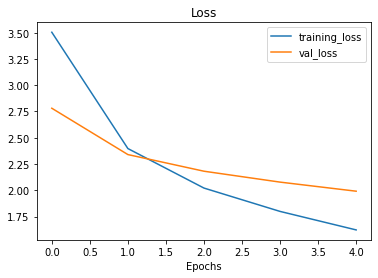

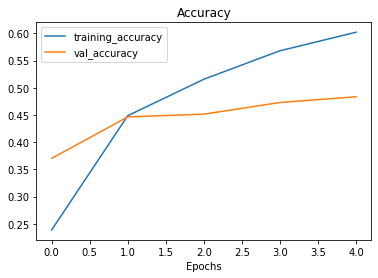

In [13]:
plot_loss_curves(history_all_classes_10_percent)

##Fine Tuning

In [14]:
#unfreeze all of the layers on base model
base_model.trainable =True

#refreeze every layer except last five layers
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [15]:
#recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])


In [16]:
#trainbel layers
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmenation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
#check layers trainble in base model

for layer_number ,layer in enumerate(model.layers[2].layers):

  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

##Fine tune for more 5 epochs

In [1]:
#incease epochs
fine_tune_epochs=10


#fine tune model
history_all_classes_10_percent_fine_tune =model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15*len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])



NameError: ignored

In [ ]:
#evaluate the model
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

In [ ]:
#comapre the histories with fine tune model
compare_historys(original_history=feature_exraction_results,
                  new_history=all_classes_10_percent_fine_tune_results,
                  initial_epochs=5)

##Save and Load the Model